# Aprendizaje profundo: redes convolucionales

En esta notebook implementaremos desde cero usando la librería `pytorch` la red convolucional *AlexNet*, desarrollada por Krizhevsky et al. en el 2012. En este [link](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) se puede ver el trabajo original.

## **¿Por qué es importante esta red?**

Porque fue la primer red neuronal que se entrenó en una GPU usando técnicas de *deep learning*. Además, ganó la competencia "ImageNet Large Scale Visual Recognition Challenge", obteniendo un error del 15.3%, superando por amplio margen al segundo mejor sistema (26.2% de error).


## **¿En qué consiste la red?**

El input es una imagen RGB. La red consiste en bloques secuenciales de *capas convolucionales*, seguidos de *capas totalmente conectadas* para tarea de clasificación. El output es una capa totalmente conectada, con un número de neuronas igual al número de clases:

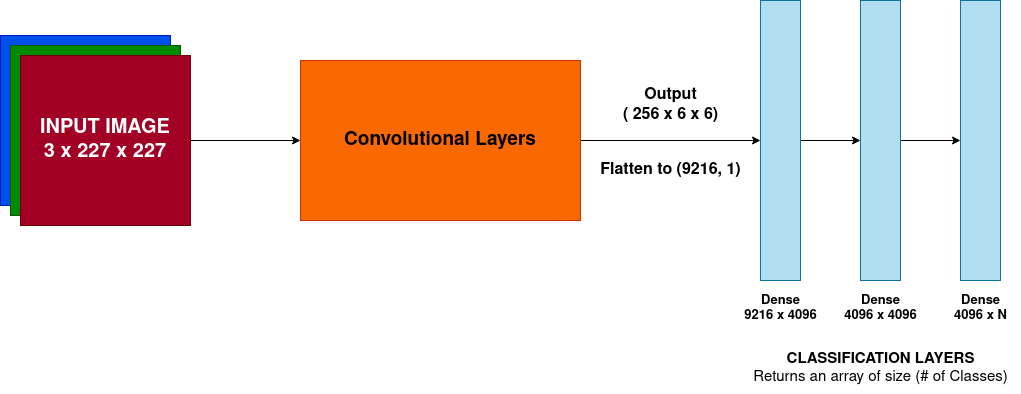

# ¿Y qué es el *bloque convolucional*?

Consiste en cinco bloques convolucionales, uno atrás del otro. El primero tiene como entrada las imágenes del dataset, y el resto tiene como entrada la salida del bloque anterior. Notemos que la dimensión del tensor cambia.

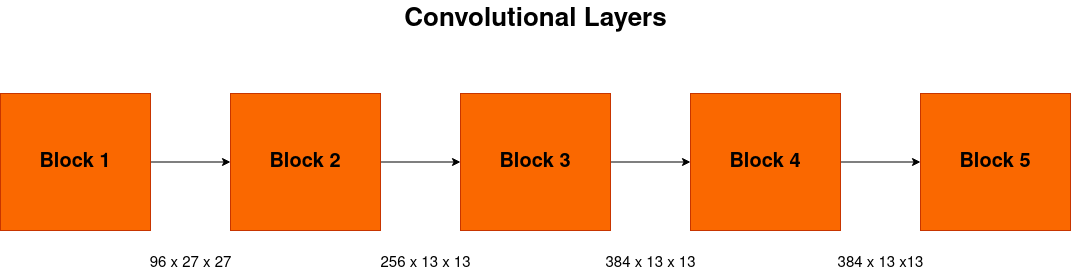

# Bueno, pero... ¿Qué es un *bloque convolucional*?

Un bloque convolucional consiste de cuatro operaciones:

* Capa convolucional
* Función de activación Relu
* Normalización
* Capa de Max Pooling


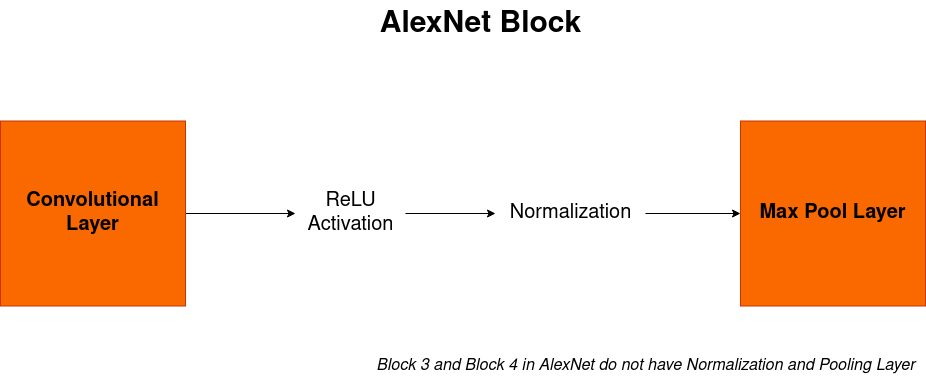


Como dice la imagen, los bloques 3 y 4 no aplican la función de activación ni la normalización. Veamos parte por parte qué hace cada cosa.

## Capa convolucional:

Realizamos la *convolución discreta* entre la imagen $W$ y el kernel $K$:

$$W_{\text{out}}[i,j] = \sum_{k,l} K[k,l]\,W[i-k,j-l] $$
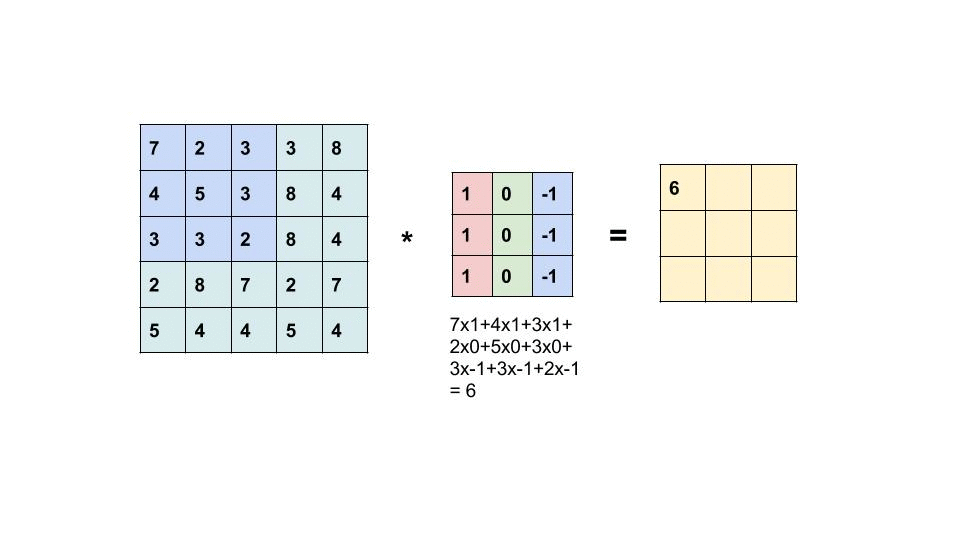



## Función de activación ReLU:

# $$y = \text{max}(0,x)$$

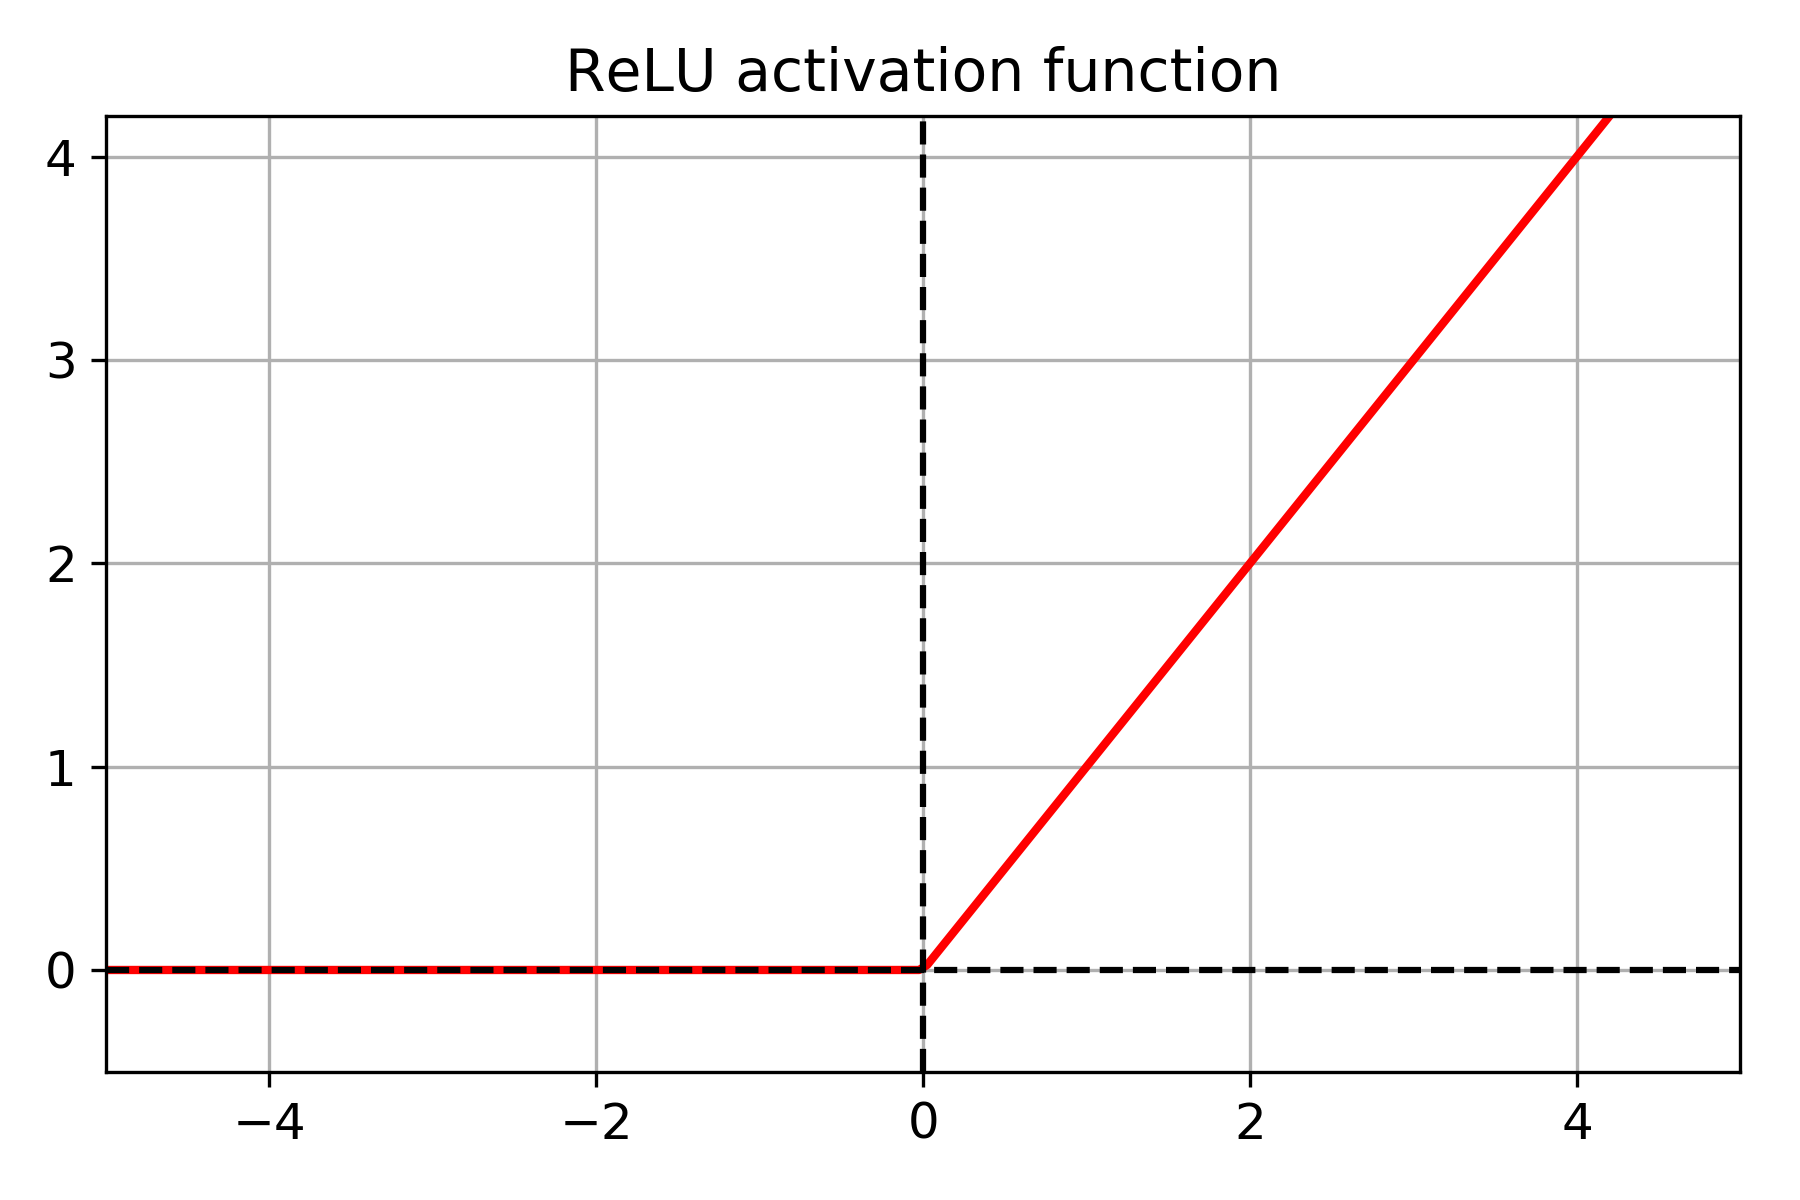

## Normalización

La normalización utilizada es `LocalResponseNormalization`:

$$b_c = a_c\left( k+\frac{\alpha}{n} \sum^{\text{min}(N-1,c+n/2)}_{c'=\text{max}(0,c-n/2)} a_{c'}^2\right)^{-\beta}$$

donde $\alpha$ es un factor multiplicativo, $\beta$ es el exponente, $k$ es un factor aditivo, $n$ es la cantidad de vecinos que se utiliza para la normalización y $c$ es la cantidad de canales. Según los autores, el uso de esta normalización mejora la performance. Los parámetros que usaron son:

* $\alpha = 0.001$
* $\beta = 0.75$
* $n=5$
* $k=2$



## Max Pool layer:

Nos quedamos con el valor máximo del bloque.

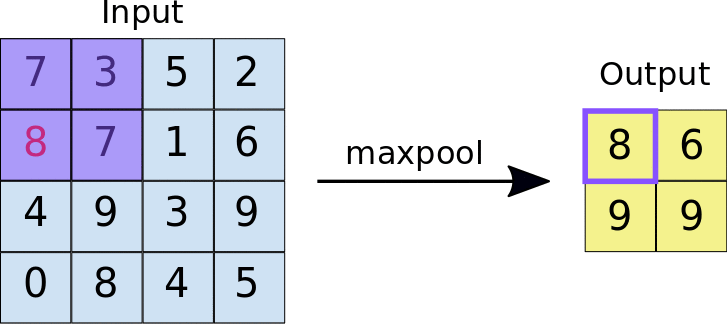

Importamos las librerías:

In [ ]:
import torch
from torch import nn

Creamos primero los bloques convolucionales, ya que son generalizables y nos evita repetir muchas líneas de código. Notar que usamos la variable booleana `pool_and_norm` para desactivar estas funciones en los bloques 3 y 4.


In [ ]:
class AlexNetBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        pool_and_norm: bool = True
    ) -> None:

        super(AlexNetBlock, self).__init__()
        self.conv_layer = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding)

        self.relu = nn.ReLU()

        self.pool_and_norm = pool_and_norm

        if pool_and_norm:
            self.norm_layer = nn.LocalResponseNorm(
                 size=5, alpha=0.0001, beta=0.75, k=2)
            self.pool_layer = nn.MaxPool2d(stride=2, kernel_size=3)


    def forward(self, x):

        x = self.conv_layer(x)
        x = self.relu(x)

        if self.pool_and_norm:
            x = self.norm_layer(x)
            x = self.pool_layer(x)

        return x

Ahora creamos la red entera usando el bloque definido en la celda anterior:

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes, in_channels) -> None:
        super(AlexNet, self).__init__()

        #in_channels, out_channels, kernel_size, stride, padding
        self.block1 = AlexNetBlock(
        in_channels, 96, 4, 2, 2, pool_and_norm=True)
        self.block2 = AlexNetBlock(96, 256, 3, 1, 1, pool_and_norm=True)
        self.block3 = AlexNetBlock(256, 384, 3, 1, 1, pool_and_norm=False)
        self.block4 = AlexNetBlock(384, 384, 2, 1, 1, pool_and_norm=False)
        self.block5 = AlexNetBlock(384, 256, 2, 1, 1, pool_and_norm=True)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024 , 4096)
#        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.classification_layer = nn.Linear(4096, num_classes)


    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.classification_layer(x)

        return x

Para entrenar esta red vamos a necesitar sí o sí una GPU:

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


# Dataset

El dataset con el que vamos a entrenar nuestra red es el CIFAR10, ya implementado en la librería `torchvision`. Consiste en muchas imágenes de aviones, autos, aves, gatos, ciervos, perros, ranas, caballos, barcos y camiones:

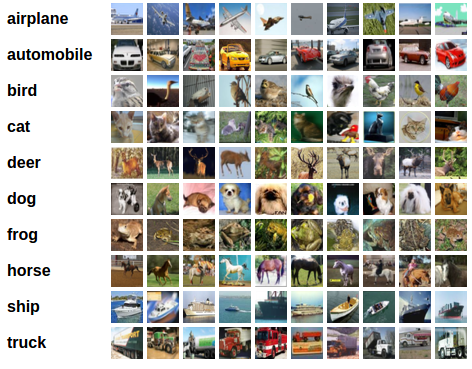

Importamos todas las librerías donde están los datasets:

In [ ]:
import os
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

Los outputs de los datasets son imágenes cuyos valores RGB están en el rango [0,1]. En nuestro caso, los transformamos a tensores normalizados en el rango [-1,1]:


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 200

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
print('largo del dataset de entrenamiento:', len(trainset))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('largo del dataset de testing:', len(testset))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
largo del dataset de entrenamiento: 50000
Files already downloaded and verified
largo del dataset de testing: 10000


Veamos algunas imágenes:

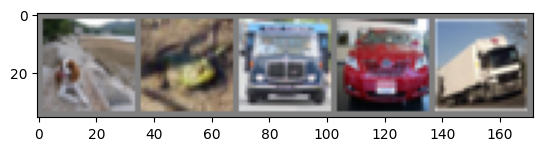

dog   frog  truck car   truck


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:5]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))


Inicializamos la red y el optimizador:

In [ ]:
import torch.optim as optim

model = AlexNet(10,3).to(device)

#adam puede no funcionar
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

Vamos a crear un método para implementar la técnica de *early stopping* para evitar el overfitting: si durante `tolerance` épocas la función de costo de validación menos la función de costo de entrenamiento es menor a `min_delta`, terminamos de entrenar la red.

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0.):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):

        if validation_loss - train_loss > self.min_delta:
            self.counter +=1
            print('check')
        else:
            self.counter = 0

        if self.counter >= self.tolerance:
            self.early_stop = True

        return self

Entrenemos la red durante ```nepochs```.

In [ ]:
nepochs = 40
ES_sw = True  # aplicamos early stopping
ES = EarlyStopping(5,0.2)

#guardamos las funciones de costo
train_loss = []
val_loss = []
for epoch in range(nepochs):  # loop sobre todo el dataset varias veces

    sum_loss = 0.0
    batch_counter = 0
    for i, data in enumerate(trainloader, 0):
        # obtengo los inputs (imágenes); data es una lista de [inputs, labels]
        inputs, labels = data

        # en cada minibatch seteamos a cero el gradiente, torch guarda los gradientes
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))  #los inputs tienen que estar en el mismo dispositivo que el modelo!!!
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        batch_counter += 1
        sum_loss += loss

    #guardamos la función de costo de entrenamiento
    train_loss_ = sum_loss.detach().to('cpu').numpy()/batch_counter
    train_loss.append(train_loss_)

    #calculamos y guardamos la función de costo para la muestra de validación
    input_val , target_val = next( iter( testloader ) )
    input_val , target_val = input_val.detach().to(device) , target_val.detach().to(device)
    with torch.no_grad():
        output_val = model( input_val )

    val_loss_ = criterion( output_val , target_val ).item()
    val_loss.append(val_loss_)

    print('train loss:',train_loss_)
    print('val loss:',val_loss_)
    print('*'*50)

    # implementamos early stopping:
    if ES_sw is True:

        if ES(train_loss_, val_loss_).early_stop is True:
            print("Hasta acá llegaste red.")

            break


print('Finished Training')

train loss: 2.30281396484375
val loss: 2.301820755004883
**************************************************
train loss: 2.3025908203125
val loss: 2.300637722015381
**************************************************
train loss: 2.301916748046875
val loss: 2.300710916519165
**************************************************
train loss: 2.2983583984375
val loss: 2.2861249446868896
**************************************************
train loss: 2.172775634765625
val loss: 2.0176198482513428
**************************************************
train loss: 1.9317528076171875
val loss: 1.9711934328079224
**************************************************
train loss: 1.7993369140625
val loss: 1.7580777406692505
**************************************************
train loss: 1.6997252197265624
val loss: 1.6538304090499878
**************************************************
train loss: 1.6207816162109374
val loss: 1.5682380199432373
**************************************************
train loss: 1.547

Guardamos la red para que no la tengamos que entrenar de nuevo cada vez que la querramos usar:

In [ ]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)


Veamos la forma que tiene nuestra función de costo. Grafiquemos la loss para el dataset de entrenamiento y validación. Vemos que al final la función de costo del dataset de entrenamiento tiende a seguir disminuyendo mientras que la del dataset de validación se estanca. Este es un buen punto para detener el entrenamiento de la red, dado que si seguimos entrenándola con los mismos ejemplos vamos a hacer un *overfitting* de los datos.  

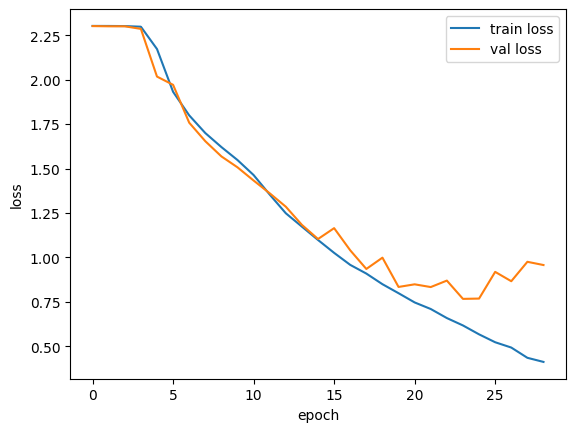

In [ ]:
#train_loss_ = [item.to('cpu').detach().numpy() for item in train_loss]
#val_loss_ = [item.to('cpu').detach().numpy() for item in val_loss]

ax = plt.figure().add_subplot(111)

ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.plot(train_loss, label='train loss')
ax.plot(val_loss, label='val loss')
ax.legend()

A continuación se muestra el caso en que no se aplicó el early stopping: La función de costo de entrenamiento sigue disminuyendo, pero la de validación se estanca e incluso aumenta, mostrando que la red sirve sólo para clasificar las imágenes que ya conoce.

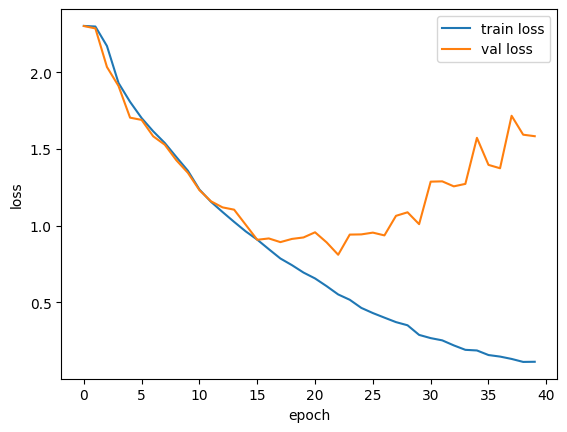

Ejemplo: cargamos nuestra red (tranquilamente podríamos haber seguido usando la cacheada).

In [ ]:
net = AlexNet(10,3).to(device)
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

Probamos la red con algunas imágenes:

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


In [ ]:
# preparamos para contar las predicciones de cada clase
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no usamos gradientes ya que no entrenamos nada
with torch.no_grad():
    for data in testloader: #iteramos sobre el conjunto de testing
        images, labels = data
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)

        # obtenemos las predicciones correctas en cada clase
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# ahora obtenemos la precisión obtenida en cada una de las clases:
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'precisión para las clases: {classname:5s} is {accuracy:.1f} %')

precisión para las clases: plane is 74.4 %
precisión para las clases: car   is 94.8 %
precisión para las clases: bird  is 62.3 %
precisión para las clases: cat   is 55.9 %
precisión para las clases: deer  is 64.6 %
precisión para las clases: dog   is 54.0 %
precisión para las clases: frog  is 83.8 %
precisión para las clases: horse is 67.4 %
precisión para las clases: ship  is 74.2 %
precisión para las clases: truck is 66.8 %


Ploteamos la matriz de confusión:

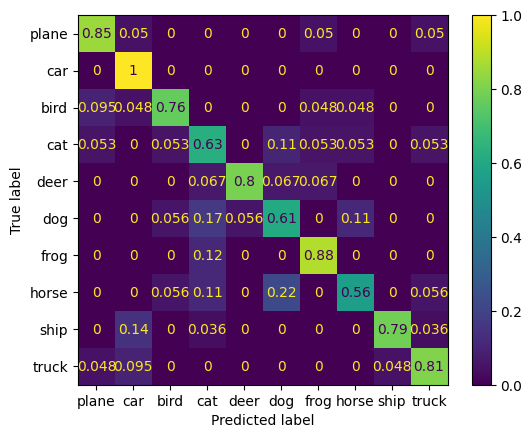

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()   #Esto le dice al modelo que lo usaremos para evaluarlo (no para entrenamiento)
input_test , target_test = next( iter( testloader ) )

#de nuevo no usamos gradiente
with torch.no_grad():
  output_test = model( input_test.to(device) )

#pasamos todo a cpu, si no no vamos a poder plotear tensores cuda
input_test_ , target_test_ = input_test.detach().cpu().numpy() , target_test.detach().cpu().numpy()
output_test_ = output_test.detach().cpu().numpy()

#obtenemos la matriz de confusión
cmatrix = confusion_matrix(
    target_test_ , torch.argmax(output_test, 1).detach().cpu().numpy(),
    normalize="true"
    )

disp = ConfusionMatrixDisplay(cmatrix, display_labels=classes)
disp.plot()


# Ejercicio 1:

Tratar de superar la precisión del clasificador mostrado en esta clase.

**Ayuda**: jugar con la profundidad de la red (quitar o agregar capas convolucionales), cambiar el tamaño de los kernels o la cantidad de neuronas en las capas totalmente conectadas. Jueguen con eso y vean.

Si quitan, agregan o modifican capas convolucionales, el tamaño del input y el output está relacionado por la ecuación

$$ o = \frac{i − k + 2p}{s} + 1$$

donde $w$ es la dimensión de la imagen, $k$ el tamaño del *kernel*, $p$ el tamaño del *padding* y $s$ el tamaño del *stride*.


**Recuerden de usar una GPU!**

# Ejercicio 2:

Construya una red U-net tal que la parte de *encoding* sea el bloque convolucional de la red Alexnet mostrada en esta notebook.

**Ayuda**: para realizar el decoding, implemente la *convolución transpuesta*. En torch, esto se hace con:

```
self.upconv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
```

donde:
* ```in_channels``` es el número de canales de la imagen de entrada,
* ```out_channels``` es el número de canales de la imagen de salida,
* ```kernel_size``` es el tamaño del kernel,
* ```stride``` controla el paso de la correlación cruzada en la aplicación del kernel,
* ```padding``` maneja la cantidad de ceros que agrega en los bordes de la imagen,

El tamaño de la imagen de salida tiene dimensión

$$ o = (i-1)\,s + k - 2p $$

donde $o$ es el tamaño de salida, $i$ el de entrada, $s$ es el stride, $k$ es el kernel y $p$ es el padding.

para más detalles, acá hay un [link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) donde tiene animaciones muy lindas mostrando qué hace cada parámetro en la convolución y convolución transpuesta.
